In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv('song_genre_list_all.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('song_id', axis=1, inplace=True)
df.drop('All', axis=1, inplace=True)
df.drop('processed_song_tag', axis=1, inplace=True)

In [21]:
df.head()

,곡 제목,아티스트 리스트,song_genre,song_deatil_genre,song_tag,앨범 명
0,Back To December,Taylor Swift,포크블루스컨트리,세부장르전체 컨트리,휴식 힐링 까페 드라이브 팝송입문 취향저격노래 인생곡 출근길 아침 여행 감각적 기분...,Speak Now (Deluxe Package)
1,설렘이라는 건,펜타곤,아이돌 발라드,남자 아이돌 10 세부장르전체 발라드,추억 기분전환 회상 아이돌의숨은명곡 달달 명곡 슬픔 아이돌,DEMO_01
2,With You,여희,댄스,세부장르전체,댄스 봄 설렘 사랑 발라드 락,Beautiful Day
3,Home,Sean Lennon,록메탈,90 모던록 세부장르전체,겨울 감성 카페 요코 비틀즈 존레논 팝 우울,Into The Sun
4,0826 사적인,어어부 프로젝트,인디음악 록메탈,세부장르전체 록 10,음악,탐정명 나그네의 기록


In [22]:
df.shape

(1965, 6)

In [24]:
df['song_tag'] = df['song_tag'].apply(lambda x : x.split())

In [27]:
df.head()

,곡 제목,아티스트 리스트,song_genre,song_deatil_genre,song_tag,앨범 명
0,Back To December,Taylor Swift,포크블루스컨트리,세부장르전체 컨트리,"[휴식, 힐링, 까페, 드라이브, 팝송입문, 취향저격노래, 인생곡, 출근길, 아침,...",Speak Now (Deluxe Package)
1,설렘이라는 건,펜타곤,아이돌 발라드,남자 아이돌 10 세부장르전체 발라드,"[추억, 기분전환, 회상, 아이돌의숨은명곡, 달달, 명곡, 슬픔, 아이돌]",DEMO_01
2,With You,여희,댄스,세부장르전체,"[댄스, 봄, 설렘, 사랑, 발라드, 락]",Beautiful Day
3,Home,Sean Lennon,록메탈,90 모던록 세부장르전체,"[겨울, 감성, 카페, 요코, 비틀즈, 존레논, 팝, 우울]",Into The Sun
4,0826 사적인,어어부 프로젝트,인디음악 록메탈,세부장르전체 록 10,[음악],탐정명 나그네의 기록


In [25]:
from gensim import corpora
from gensim import models

In [28]:
len(df['song_tag'][0])

43

In [29]:
# 인덱스를 만들어주고, x에 내용 전처리
def index_rmv(x):
    index = []
    for i in range(len(x)):
        if len(x[i]) == 1:
            index.append(i)
    
    index.sort(reverse = True)
    
    for num in index:
        del x[num] # 한글자 짜리 단어는 지우겠다
    return x

In [30]:
df['index_rmv'] = df['song_tag'].apply(lambda x : index_rmv(x))

In [35]:
# 단어 행렬 쌓는 함수
def build_doc_word_matrix(docs):
    # 딕셔너리 형태
    dictionary = corpora.Dictionary(docs)
    corpus = []
    for doc in docs:
        bow = dictionary.doc2bow(doc)
        corpus.append(bow)

    return corpus, dictionary

In [37]:
corpus, dictionary = build_doc_word_matrix(df['index_rmv'])

In [40]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4505
Number of documents: 1965


In [94]:
import matplotlib.pyplot as plt

import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

In [99]:
df['tag_count'] = df['index_rmv'].apply(lambda x : len(x))

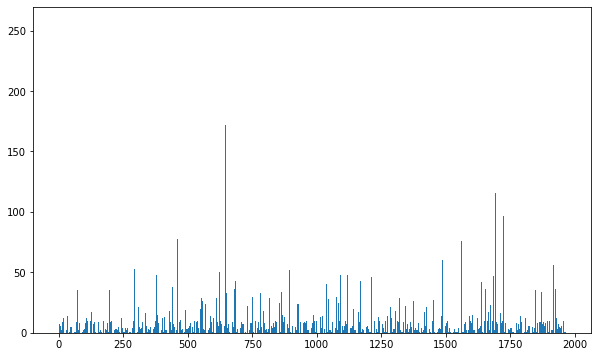

In [101]:
plt.bar(df.index, df['tag_count'])
plt.show()

In [102]:
df['tag_count'].describe()

count    1965.000000
mean       11.427990
std        21.393737
min         0.000000
25%         2.000000
50%         6.000000
75%        10.000000
max       257.000000
Name: tag_count, dtype: float64

In [103]:
df[df['tag_count'] == 257]

,곡 제목,아티스트 리스트,song_genre,song_deatil_genre,song_tag,앨범 명,index_rmv,tag_count
64,1월부터 6월까지,윤종신,발라드,10 세부장르전체,"[눈물, 발라드, 겨울, 매장음악, 카페, 주말, 겨울밤, 새벽감성, 밤새벽, 추위...",행보 2013 윤종신,"[눈물, 발라드, 겨울, 매장음악, 카페, 주말, 겨울밤, 새벽감성, 밤새벽, 추위...",257


In [105]:
pro_df = df[df['tag_count'] > 4]
pro_df.shape

(1076, 8)

In [106]:
pro_df.columns

Index(['곡 제목', '아티스트 리스트', 'song_genre', 'song_deatil_genre', 'song_tag',
       '앨범 명', 'index_rmv', 'tag_count'],
      dtype='object')

In [41]:
from gensim.models import CoherenceModel

In [107]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    # LDA 모델 함수
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus, num_topics=num_topics,
                        id2word=dictionary,
                        alpha='auto')        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [123]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus,
                                                        texts=df['index_rmv'], start=2, limit=40, step=6)

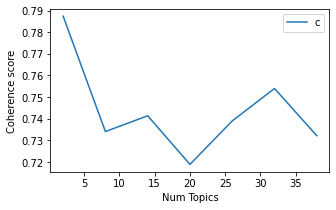

In [124]:
plt.rcParams['figure.figsize'] = [5, 3]
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();

# coherence score은 높거나 낮음이 좋고 나쁨이 없다
# 적당한 보완을 찾는 것
# 그림처럼 "산" 모양이 이상적

In [125]:
def print_topic_words(model):
    f = open('topic_results_test.txt','w')
    for topic_id in range(model.num_topics):
        word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        f.write(str(topic_id)+'\n')
        for word, prob in word_probs:
            print("\t{}\t{}".format(word, prob))
            f.write(str(word)+'\t'+str(prob)+'\n')
        print("\n")
    f.close()

In [139]:
# 하이퍼파라미터
NUM_TOPICS = 5
NUM_TOPIC_WORDS = 20

In [142]:
lda_model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                            id2word=dictionary,
                            alpha='auto')
print_topic_words(lda_model)

Topic ID: 0
	기분전환	0.020966438576579094
	잔잔한	0.016097022220492363
	새벽	0.0154725955799222
	매장음악	0.014649435877799988
	드라이브	0.013170667923986912
	신나는	0.01268806867301464
	감성	0.009705907665193081
	카페	0.009245943278074265
	까페	0.0088352020829916
	알앤비	0.00777884665876627
	사랑	0.007133734878152609
	소울	0.006468122825026512
	뉴에이지	0.0064374529756605625
	여행	0.006318545900285244
	댄스	0.006026087794452906
	힙합	0.005859564058482647
	비오는날	0.005688539706170559
	휴식	0.005517594516277313
	스트레스	0.005415498279035091
	매장	0.0050420863553881645


Topic ID: 1
	발라드	0.015165229327976704
	감성	0.012653087265789509
	드라이브	0.012612265534698963
	기분전환	0.011937446892261505
	여행	0.011669671162962914
	인디	0.011083874851465225
	잔잔한	0.009855814278125763
	사랑	0.009544450789690018
	휴식	0.00909089669585228
	새벽	0.008689414709806442
	추억	0.00823501031845808
	힐링	0.008144574239850044
	일렉	0.007828403264284134
	카페	0.007353499066084623
	여름	0.007255141623318195
	운동	0.0072327544912695885
	힙합	0.007004937157034874
	신나는	0.006894940044730902
	설렘	0.0

In [143]:
words_per_topics = [list() for topic_id in range(NUM_TOPICS)]

for topic_id in range(lda_model.num_topics):
    word_probs = lda_model.show_topic(topic_id, NUM_TOPIC_WORDS)
    for word, prob in word_probs:
        words_per_topics[topic_id].append(word)

In [129]:
pd.DataFrame(words_per_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,힐링,잔잔한,휴식,기분전환,발라드,사랑,새벽,감성,카페,이별,비오는날,드라이브,여행,인디,겨울,매장음악,설렘,힙합,일렉,스트레스
1,기분전환,힙합,힐링,새벽,감성,휴식,추억,회상,드라이브,잔잔한,댄스,신나는,여행,알앤비,Pop,사랑,발라드,가을,슬픔,운동
2,기분전환,드라이브,감성,휴식,카페,잔잔한,발라드,사랑,스트레스,새벽,매장음악,추억,힐링,신나는,여름,설렘,여행,재즈,가을,알앤비


In [138]:
pd.DataFrame(words_per_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,기분전환,여행,감성,휴식,드라이브,잔잔한,힐링,산책,알앤비,가을,Pop,카페,새벽,발라드,추억,사랑,슬픔,이별,겨울,스트레스
1,휴식,힐링,잔잔한,새벽,힙합,기분전환,카페,감성,겨울,댄스,사랑,매장음악,발라드,분위기,가을,이별,드라이브,알앤비,여행,운동
2,발라드,기분전환,새벽,감성,드라이브,잔잔한,일렉,비오는날,카페,클래식,이별,신나는,인디,힙합,설렘,가을,추억,힐링,휴식,사랑
3,기분전환,드라이브,감성,힐링,사랑,추억,휴식,잔잔한,스트레스,새벽,회상,매장음악,발라드,신나는,설렘,힙합,카페,뉴에이지,인디,댄스


In [144]:
pd.DataFrame(words_per_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,기분전환,잔잔한,새벽,매장음악,드라이브,신나는,감성,카페,까페,알앤비,사랑,소울,뉴에이지,여행,댄스,힙합,비오는날,휴식,스트레스,매장
1,발라드,감성,드라이브,기분전환,여행,인디,잔잔한,사랑,휴식,새벽,추억,힐링,일렉,카페,여름,운동,힙합,신나는,설렘,Pop
2,기분전환,감성,사랑,드라이브,힐링,스트레스,휴식,발라드,잔잔한,새벽,카페,설렘,댄스,매장음악,추억,재즈,운동,뉴에이지,이별,힙합
3,힙합,기분전환,클래식,재즈,드라이브,Pop,스트레스,휴식,힐링,발라드,신나는,여행,클럽,EDM,감성,잔잔한,비오는날,댄스,가을,이별
4,휴식,힐링,감성,잔잔한,추억,새벽,드라이브,회상,기분전환,카페,발라드,가을,힙합,겨울,스트레스,비오는날,매장음악,사랑,여행,슬픔


In [130]:
#!pip install pyLDAvis

In [131]:
import pyLDAvis

#pyLDAvis.enable_notebook()

#import pyLDAvis.gensim as gensimvis
import pyLDAvis.gensim_models as gensim

In [132]:
prepared_data = gensim.prepare(lda_model, corpus, dictionary)

In [133]:
pyLDAvis.display(prepared_data)

In [134]:
pyLDAvis.save_html(prepared_data, '멜론 태그 LDA.html')